# Abstract

This notebook aims to train PARSeq-like OCR Model for Khmer language.

In [1]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.4 MB/s eta 0:00:00


# Data Preparation

We first prepare dataset for OCR model because we need to build tokenizer to paired with OCR model.

I will use my public dataset for this tutorial.

In [2]:
import torch
import torchvision
import torch.utils.data as dataloader
import torch.nn as nn

torch.manual_seed(168)

In [3]:
from datasets import load_dataset
data = load_dataset('Kimang18/khmer-hanuman-small-images', split='train')
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/380 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/8.05M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3374 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'height', 'width', 'text'],
    num_rows: 3374
})

This is a very small dataset having only 3374 rows.

ជ័យ(ភ្នំពេ


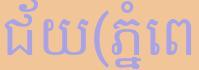

In [4]:
idx = 602
print(data['text'][idx])
data['image'][idx]

Since the dataset also contains English words, I will prepare a simple tokenizer for English and Khmer alphabets.

Each character is a token.

In [5]:
from torch import Tensor

class CharTokenizer:
    def __init__(self, chars, special_tokens=['<s>', '</s>', '<pad>', '<unk>']):
        self.special_tokens = special_tokens
        # Unique characters + special tokens
        self.vocab = tuple(special_tokens[:1]) + tuple(chars) + tuple(special_tokens[1:])
        self.str_to_int = {s: i for i, s in enumerate(self.vocab)}
        self.int_to_str = {i: s for i, s in enumerate(self.vocab)}
        self.bos_id = self.str_to_int['<s>']
        self.eos_id = self.str_to_int['</s>']
        self.pad_id = self.str_to_int['<pad>']
        self.unk_id = self.str_to_int['<unk>']

    def __len__(self):
        return len(self.vocab)

    def _tok2ids(self, tokens: str) -> list[int]:
        return [self._str_to_int[s] for s in tokens]

    def _ids2tok(self, token_ids: list[int], join: bool = True) -> str:
        tokens = [self.int_to_str[i] for i in token_ids]
        return ''.join(tokens) if join else tokens

    def encode(self, text, add_special_tokens=False):
        tokens = []
        i = 0
        while i < len(text):
            matched_special = False
            # Check for existing special tokens in the input string
            for spec in self.special_tokens:
                if text.startswith(spec, i):
                    tokens.append(self.str_to_int[spec])
                    i += len(spec)
                    matched_special = True
                    break

            if not matched_special:
                char = text[i]
                tokens.append(self.str_to_int.get(char, self.str_to_int['<unk>']))
                i += 1

        # Wrap with <s> and </s> if requested
        if add_special_tokens:
            tokens = [self.str_to_int['<s>']] + tokens + [self.str_to_int['</s>']]

        return tokens

    def decode(self, ids, ignore_special_tokens=False):
        if ignore_special_tokens:
            # Filter out any ID that belongs to the special_tokens list
            return "".join([self.int_to_str[i] for i in ids if self.int_to_str[i] not in self.special_tokens])

        return "".join([self.int_to_str.get(i, '<unk>') for i in ids])

In [6]:
kh_charset = "០១២៣៤៥៦៧៨៩កខគឃងចឆជឈញដឋឌឍណតថទធនបផពភមយរលវសហឡអឥឧឳឪឱឫឬឭឮឦឰឯាិីឹឺុូួើឿៀេែៃោៅំះៈ់៉៊៍័៏៌្ ។៕៖ៗ"
en_charset = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
tokenizer = CharTokenizer(en_charset+kh_charset)

In [7]:
len(tokenizer)

185

Here, we have 185 tokens in our vocabulary.

In [8]:
print(data[0]['text'])
print(tokenizer.decode(tokenizer.encode(data[0]['text'], add_special_tokens=True), ignore_special_tokens=False))

ក្នុងនោះរួ
<s>ក្នុងនោះរួ</s>


Max length: 17
Min length: 3


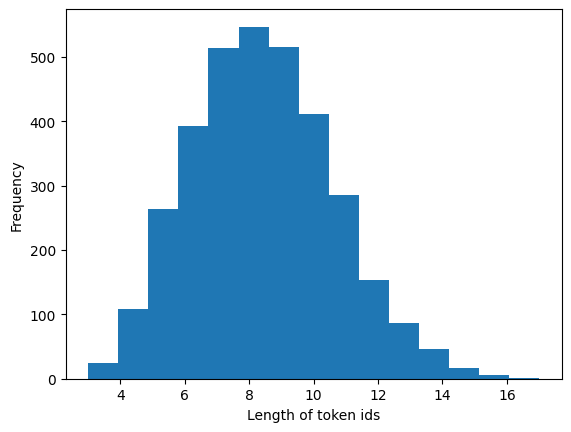

In [9]:
from matplotlib import pyplot as plt
token_ids_lengths = []
for d in data:
    token_ids_lengths.append(len(tokenizer.encode(d['text'], add_special_tokens=False)))

print(f"Max length: {max(token_ids_lengths)}")
print(f"Min length: {min(token_ids_lengths)}")
plt.hist(token_ids_lengths, bins=15)
plt.ylabel('Frequency')
plt.xlabel('Length of token ids');

With this histogram, we learn that any row has at least 3 tokens (or 3 characters) and at most 17 tokens (or 17 characters).

When making dataset for training, the maximum sequence length is 18 as we add `begin_of_sequence` token (denoted by `<s>`) to the decoder input sequence, and `end_of_sequence` token (denoted by `</s>`) to the decoder target sequence.

We create `KmDataset` object by converting text into sequence of token ids using `encode` function of our tokenizer.

In [10]:
class KmDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, ds, transform) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.ds = ds
        self.transform = transform

    def __getitem__(self, index):
        data_point = self.ds[index]
        tok_ids = self.tokenizer.encode(data_point['text'], add_special_tokens=True)
        return {
            'img_tensor': self.transform(data_point['image']),
            'token_ids': tok_ids,
        }

    def __len__(self):
        return len(self.ds)

In [11]:
from torchvision.transforms import v2 as transforms


train_transform = transforms.Compose(
    [
        transforms.Resize((32, 128)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize((32, 128)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [12]:
SEED=168
data = data.train_test_split(0.2, seed=SEED)

train_dataset = KmDataset(tokenizer, data['train'], train_transform)
valid_dataset = KmDataset(tokenizer, data['test'], valid_transform)

In [13]:
train_dataset[0]['img_tensor'].size()

torch.Size([3, 32, 128])

## Data Collator

For data collator, we batch input sequences and target sequences of different by padding the shorter sequences to the length of the longest sequence.

In [14]:
from torch.nn.utils.rnn import pad_sequence
import numpy as np


class DataCollatorWithPadding:
    def __call__(self, features):
        imgs, inp_tids, tgt_tids = [], [], []
        for feature in features:
            imgs.append(feature['img_tensor'])
            inp_tids.append(torch.as_tensor(feature['token_ids'][:-1]))
            tgt_tids.append(torch.as_tensor(feature['token_ids'][1:]))

        tgt_tids = pad_sequence(tgt_tids, batch_first=True, padding_value=tokenizer.pad_id)
        inp_tids = pad_sequence(inp_tids, batch_first=True, padding_value=tokenizer.pad_id)

        batch = {
            "target_ids": tgt_tids,
            "input_ids": inp_tids,
        }

        batch['img_tensor'] = torch.stack(imgs)
        return batch

Let's test our loader here.

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    collate_fn=DataCollatorWithPadding()
)

In [16]:
batch = next(iter(train_loader))

In [17]:
print(batch['input_ids'].shape)
print(batch['target_ids'].shape)
print(batch['img_tensor'].shape)

torch.Size([2, 11])
torch.Size([2, 11])
torch.Size([2, 3, 32, 128])


In [18]:
for target, input in zip(batch['target_ids'], batch['input_ids']):
    print(tokenizer.decode(input.tolist()))
    print(tokenizer.decode(target.tolist()))

<s>ពិតមែន<pad><pad><pad><pad>
ពិតមែន</s><pad><pad><pad><pad>
<s>កថ្ម ។លទ្ធ
កថ្ម ។លទ្ធ</s>


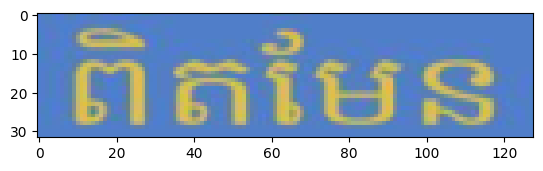

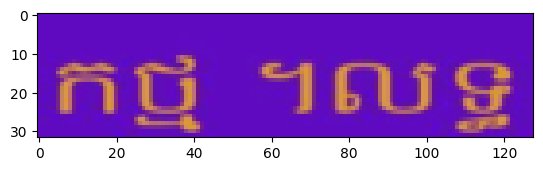

In [19]:
import matplotlib.pyplot as plt

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
for img in batch['img_tensor']:
    plt.imshow((img.permute(1, 2, 0) * std + mean))
    plt.show()

# Prepare Model

In this tutorial, I will use ready-to-use Vision Transformer for image feature extractor.
Moreover, I will use the pretrained-weight of PARSeq-tiny for the Image Encoder.

In [20]:
from timm.models.vision_transformer import PatchEmbed, VisionTransformer


class ImageEncoder(VisionTransformer):
	def __init__(self, config):
		super().__init__(
			img_size=config.img_size,
			patch_size=config.patch_size,
			in_chans=config.n_channel,
			embed_dim=config.n_embed,
			depth=config.n_layer,
			num_heads=config.n_head,
			mlp_ratio=4,
			qkv_bias=True,
			drop_rate=0.0,
			attn_drop_rate=0.0,
            drop_path_rate=0.0,
			embed_layer=PatchEmbed,
			num_classes=0, # These
			global_pool='', # disable the
			class_token=False, # classifier head.
		)

	def forward(self, x):
		return self.forward_features(x)

In [21]:
from typing import Sequence, Optional
from dataclasses import dataclass
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import random
import math


class RMSNorm(nn.RMSNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


class Linear(nn.Linear):
    def forward(self, x: Tensor) -> Tensor:
        return F.linear(
            x,
            self.weight.to(x.dtype),
            None if self.bias is None else self.bias.to(x.dtype)
        )


class TextDecoder(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config
        self.n_head = 2 * config.n_head
        self.tok_embed = nn.Embedding(config.vocab_size, config.n_embed)
        self.pos_embed = nn.Parameter(torch.Tensor(1, config.block_size, config.n_embed))
        self.dropout = nn.Dropout(config.dropout)

        self.sa_ln = RMSNorm(config.n_embed)
        self.sa_attn = nn.MultiheadAttention(config.n_embed, self.n_head, dropout=config.dropout, batch_first=True)

        self.cross_ln = RMSNorm(config.n_embed)
        self.cross_attn = nn.MultiheadAttention(config.n_embed, self.n_head, dropout=config.dropout, batch_first=True)

        self.ffn_ln = RMSNorm(config.n_embed)
        dim_feedforward = 4*config.n_embed
        self.ffn = nn.Sequential(
            Linear(config.n_embed, dim_feedforward, bias=config.bias),
            nn.GELU(),
            Linear(dim_feedforward, config.n_embed, bias=config.bias),
            nn.Dropout(config.dropout)
        )
        self.lm_head = Linear(config.n_embed, config.vocab_size)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x: Tensor, xi: Tensor, targets: Tensor=None):
        b, t = x.size()
        tok_embed = self.tok_embed(x)
        query = self.dropout(tok_embed + self.pos_embed[:, :t]) # (b, t, n_embed)
        mask = torch.triu(torch.ones((t, t), dtype=torch.bool, device=x.device), 1)

        res = query
        query = self.sa_ln(res)
        query, sa_weights = self.sa_attn(query, query, query, attn_mask=mask)
        res = res + query
        query, ca_weights = self.cross_attn(self.cross_ln(res), xi, xi)
        res = res + query
        res = res + self.ffn(self.ffn_ln(res))

        if targets is not None:
            logits = self.lm_head(res).float()
            loss = F.cross_entropy(logits.flatten(end_dim=1), targets.flatten(), ignore_index=tokenizer.pad_id)
            return logits, loss
        else:
            return self.lm_head(res[:, [-1], :]).float(), _


@dataclass
class ModelConfig:
    img_size: Sequence[int]
    patch_size: Sequence[int]
    n_channel: int
    vocab_size: int
    block_size: int
    n_layer: int
    n_head: int
    n_embed: int
    dropout: float = 0.0
    bias: bool = True

In [22]:
class OCRModel(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.encoder = ImageEncoder(config)
        self.decoder = TextDecoder(config)

    def forward(self, img_tensor: Tensor, input_tokens: Tensor, targets_tokens: Tensor=None):
        xi = self.encoder(img_tensor)
        logits, loss = self.decoder(input_tokens, xi, targets_tokens)
        return logits, loss

    @torch.inference_mode()
    def generate(self, img_tensor: Tensor, max_new_tokens: int, temperature=1.0, top_k=None):
        xi = self.encoder(img_tensor.unsqueeze(0))
        idx = torch.full((xi.size(0),1), fill_value=tokenizer.bos_id, dtype=torch.long, device=img_tensor.device)
        for i in range(max_new_tokens):
            logits, _ = self.decoder(idx, xi)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next.item() == tokenizer.eos_id:
                break
        return idx

In [23]:
config = ModelConfig(
    img_size=(32, 128),
    patch_size=(4, 8),
    n_channel=3,
    vocab_size=len(tokenizer),
    block_size=32,
    n_layer=12,
    n_head=3,
    n_embed=192,
    dropout=0.1,
    bias=True,
)
model = OCRModel(config)

In [24]:
with torch.inference_mode():
    batch = next(iter(train_loader))
    logits, loss = model(batch['img_tensor'], batch['input_ids'].long(), batch['target_ids'].long())

In [25]:
print(logits.size())
pred = logits.argmax(dim=-1)
print(pred)

torch.Size([2, 11, 185])
tensor([[177,  41, 171, 155, 171, 160,  20,  22, 179, 179, 179],
        [147, 120, 113, 114,  97,  56,  66,  22, 179, 114, 106]])


In [26]:
for token in pred:
    print(tokenizer.decode(token.tolist()))

 E៊ុ៊ៀjl៕៕៕
ឦតឈញ២T$l៕ញខ


In [27]:
pred = model.generate(batch['img_tensor'][0], 32)
print(tokenizer.decode(pred[0].tolist()))

<s>ឺ <?ថញSz}ែdZឃឪFq=;ខ46yឥឥយៗv|3kR%


## Load Pretrained Weight for Encoder

In [28]:
import torch
m = torch.hub.load_state_dict_from_url('https://github.com/baudm/parseq/releases/download/v1.0.0/parseq_tiny-e7a21b54.pt', map_location=torch.device('cpu'))

Downloading: "https://github.com/baudm/parseq/releases/download/v1.0.0/parseq_tiny-e7a21b54.pt" to /root/.cache/torch/hub/checkpoints/parseq_tiny-e7a21b54.pt


100%|██████████| 23.0M/23.0M [00:00<00:00, 75.5MB/s]


In [29]:
encoder_layers = {}
for k, v in m.items():
    print(k)
    if 'encoder' in k:
        encoder_layers[k.split('encoder.')[1]] = v

pos_queries
encoder.pos_embed
encoder.patch_embed.proj.weight
encoder.patch_embed.proj.bias
encoder.blocks.0.norm1.weight
encoder.blocks.0.norm1.bias
encoder.blocks.0.attn.qkv.weight
encoder.blocks.0.attn.qkv.bias
encoder.blocks.0.attn.proj.weight
encoder.blocks.0.attn.proj.bias
encoder.blocks.0.norm2.weight
encoder.blocks.0.norm2.bias
encoder.blocks.0.mlp.fc1.weight
encoder.blocks.0.mlp.fc1.bias
encoder.blocks.0.mlp.fc2.weight
encoder.blocks.0.mlp.fc2.bias
encoder.blocks.1.norm1.weight
encoder.blocks.1.norm1.bias
encoder.blocks.1.attn.qkv.weight
encoder.blocks.1.attn.qkv.bias
encoder.blocks.1.attn.proj.weight
encoder.blocks.1.attn.proj.bias
encoder.blocks.1.norm2.weight
encoder.blocks.1.norm2.bias
encoder.blocks.1.mlp.fc1.weight
encoder.blocks.1.mlp.fc1.bias
encoder.blocks.1.mlp.fc2.weight
encoder.blocks.1.mlp.fc2.bias
encoder.blocks.2.norm1.weight
encoder.blocks.2.norm1.bias
encoder.blocks.2.attn.qkv.weight
encoder.blocks.2.attn.qkv.bias
encoder.blocks.2.attn.proj.weight
encoder.bloc

In [30]:
model.encoder.load_state_dict(encoder_layers, strict=False)

<All keys matched successfully>

In [31]:
# freeze encoder weights
for p in model.encoder.parameters():
    p.requires_grad = False

In [32]:
num_param = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad) / 1e6
print(f"Encoder num of trainable parameters: {num_param}")
num_param = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad) / 1e6
print(f"Decoder num of trainable parameters: {num_param}")
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"OCR num of trainable parameters: {num_param}")

num_param = sum(p.numel() for p in model.encoder.parameters()) / 1e6
print(f"Encoder num of parameters: {num_param}")
num_param = sum(p.numel() for p in model.decoder.parameters()) / 1e6
print(f"Decoder num of parameters: {num_param}")
num_param = sum(p.numel() for p in model.parameters()) / 1e6
print(f"OCR num of parameters: {num_param}")

Encoder num of trainable parameters: 0.0
Decoder num of trainable parameters: 0.670265
OCR num of trainable parameters: 0.670265
Encoder num of parameters: 5.381952
Decoder num of parameters: 0.670265
OCR num of parameters: 6.052217


# Device, Model, Optimizer

In [33]:
from contextlib import nullcontext


device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
print(ptdtype)

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
torch.manual_seed(168)

torch.bfloat16


In [34]:
batch_size = 4
learning_rate = 2e-3

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(), shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, collate_fn=DataCollatorWithPadding())

epochs = 5
grad_accum = 2
max_steps = int(epochs * len(train_loader) / grad_accum)
print(max_steps)

1687


In [35]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95))

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    total_steps=max_steps,
    pct_start=0.1,
    anneal_strategy='cos',
    final_div_factor=20,
)

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

model = model.to(device)

# Train Loop

In [36]:
def valid_loss(model):
    total_loss = 0
    model.eval()
    with torch.inference_mode():
        for batch_idx, batch in enumerate(valid_loader):
            imgs, input_tokens, target_tokens = batch['img_tensor'], batch['input_ids'], batch['target_ids']
            imgs, input_tokens, target_tokens = imgs.to(device), input_tokens.long().to(device), target_tokens.long().to(device)

            with ctx:
                logits, loss = model(imgs, input_tokens, target_tokens)

            total_loss += loss.item()
    model.train()
    return total_loss / batch_idx


Epoch 1
 Batch   1: Loss = 5.2463, LR = 0.00008
 Batch 181: Loss = 3.2710, LR = 0.00115
 Batch 361: Loss = 2.6207, LR = 0.00200
 Batch 541: Loss = 1.8608, LR = 0.00198
==> Epoch 1 Summary: Total Loss = 1010.5588
==> Epoch 1 Summary: Avg Validation Loss = 1.9534
ត្តក្នុងក


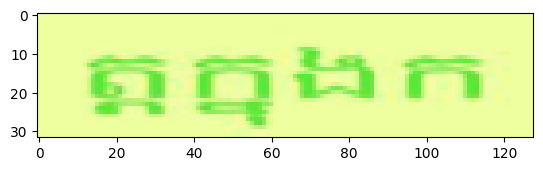


Epoch 2
 Batch   1: Loss = 2.1070, LR = 0.00194
 Batch 181: Loss = 1.9862, LR = 0.00186
 Batch 361: Loss = 1.4953, LR = 0.00175
 Batch 541: Loss = 1.8575, LR = 0.00162
==> Epoch 2 Summary: Total Loss = 471.3366
==> Epoch 2 Summary: Avg Validation Loss = 1.1969
ស់មិនចង់


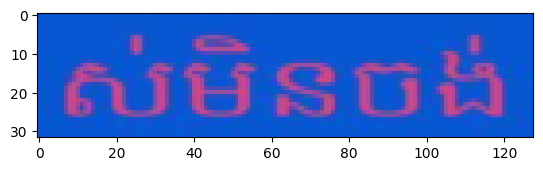


Epoch 3
 Batch   1: Loss = 0.8584, LR = 0.00150
 Batch 181: Loss = 0.9510, LR = 0.00133
 Batch 361: Loss = 0.7394, LR = 0.00115
 Batch 541: Loss = 0.5987, LR = 0.00097
==> Epoch 3 Summary: Total Loss = 269.0060
==> Epoch 3 Summary: Avg Validation Loss = 0.9074
បានរៀបរាប់


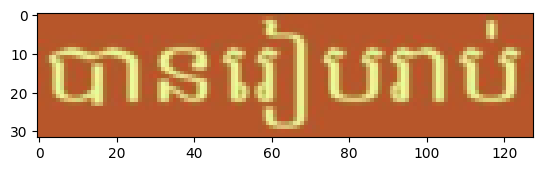


Epoch 4
 Batch   1: Loss = 0.7082, LR = 0.00083
 Batch 181: Loss = 0.8077, LR = 0.00065
 Batch 361: Loss = 0.5526, LR = 0.00048
 Batch 541: Loss = 0.4504, LR = 0.00033
==> Epoch 4 Summary: Total Loss = 152.6080
==> Epoch 4 Summary: Avg Validation Loss = 0.7609
ចប់ការប្រ


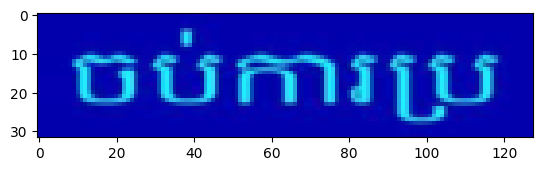


Epoch 5
 Batch   1: Loss = 0.2122, LR = 0.00024
 Batch 181: Loss = 0.3663, LR = 0.00013
 Batch 361: Loss = 0.1118, LR = 0.00006
 Batch 541: Loss = 0.3102, LR = 0.00001
==> Epoch 5 Summary: Total Loss = 96.9945
==> Epoch 5 Summary: Avg Validation Loss = 0.7388
កណ្តាលរ


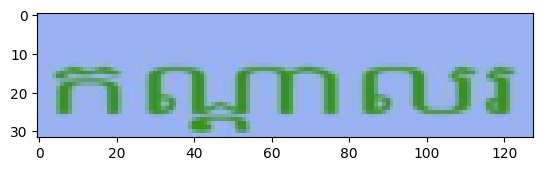

In [37]:
optimizer.zero_grad(set_to_none=True)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    val_loss = np.inf
    total_epoch = 0
    print(f"\nEpoch {epoch + 1}")

    for batch_idx, batch in enumerate(train_loader):
        imgs, input_tokens, target_tokens = batch['img_tensor'], batch['input_ids'], batch['target_ids']
        imgs, input_tokens, target_tokens = imgs.to(device), input_tokens.long().to(device), target_tokens.long().to(device)

        with ctx:
            logits, loss = model(imgs, input_tokens, target_tokens)
            loss = loss / grad_accum
            scaler.scale(loss).backward()

        if ((batch_idx + 1) % grad_accum == 0) or (batch_idx + 1 == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if (batch_idx + 1) % grad_accum == 0:
                scheduler.step()

        total_loss += loss.item()
        lrs = [group['lr'] for group in optimizer.param_groups]

        if batch_idx % 180 == 0:
            print(f" Batch {batch_idx+1:3d}: Loss = {grad_accum * loss.item():.4f}, LR = {lrs[0]:.5f}")

    # epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}")
    curr_val_loss = valid_loss(model)
    if curr_val_loss < val_loss:
        val_loss = curr_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    print(f"==> Epoch {epoch+1} Summary: Avg Validation Loss = {curr_val_loss:.4f}")

    target = target_tokens[0]
    print(tokenizer.decode(target.tolist(), ignore_special_tokens=True))
    plt.imshow((imgs[0].cpu().permute(1, 2, 0) * std + mean))
    plt.show()

នសម្រេច
នសម្រេច


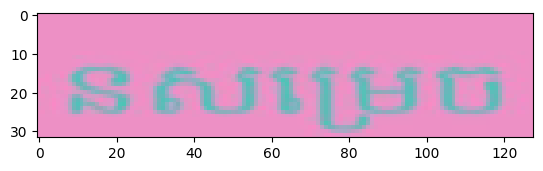

ផ្តអង
ជង្គង់


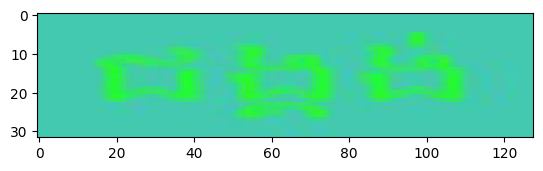

បានជើ
បានធ្វើ


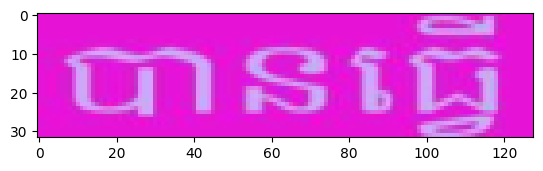

ន ។ផ្ទង ហើ
ន រស់ បា


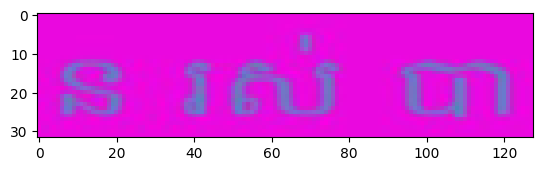

ផ្តល់កាព
ផ្ដល់ភាព


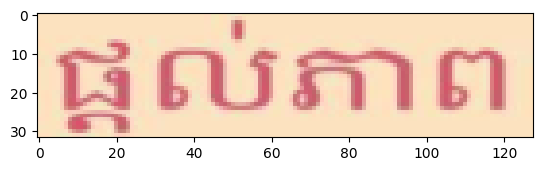

ដែលស្អ
ដែលល្អ


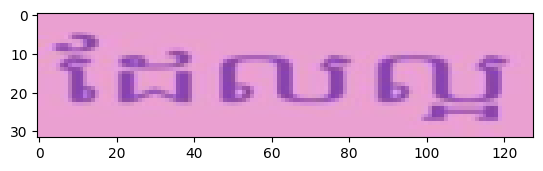

គានទីពីង
គ្មានទីពឹង


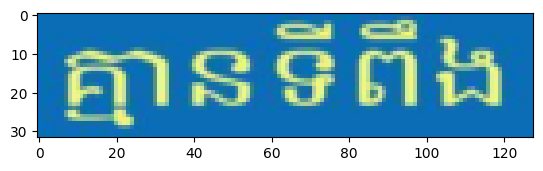

ចេវាំច ប ប្ញ
ថេរ៉ាយុ វិញ


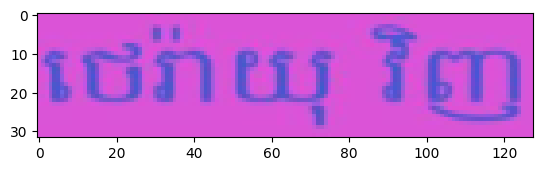

In [38]:
batch = next(iter(valid_loader))
imgs, target_tokens = batch['img_tensor'], batch['target_ids']
imgs, target_tokens = imgs.to(device), target_tokens.long().to(device)

for img, target in zip(imgs, target_tokens):
    pred = model.generate(img, 32, temperature=0.001)
    print(tokenizer.decode(pred[0].tolist()[1:-1], ignore_special_tokens=True))
    print(tokenizer.decode(target.tolist(), ignore_special_tokens=True))
    plt.imshow(img.cpu().permute(1, 2, 0) * std + mean)
    plt.show();

In [39]:
model = OCRModel(config)
model.load_state_dict(torch.load('best_model.pt'))
model = model.to(device)

In [43]:
model.eval()
refs = []
preds = []
for batch_idx, batch in enumerate(valid_loader):
    imgs, target_tokens = batch['img_tensor'], batch['target_ids']
    imgs, target_tokens = imgs.to(device), target_tokens.long().to(device)
    for img, target in zip(imgs, target_tokens):
        pred = model.generate(img, 32, temperature=0.001)
        refs.append(tokenizer.decode(target.tolist(), ignore_special_tokens=True))
        preds.append(tokenizer.decode(pred[0].tolist()[1:-1]))

In [44]:
import evaluate

cer_metrics = evaluate.load('cer')
cer_metrics.compute(references=refs, predictions=preds)

0.32214647788848105

In [45]:
for r, p in zip(refs, preds):
    print('Pred: ', p)
    print('Refe: ', r)
    print(10*'=')

Pred:  នសម្រេច
Refe:  នសម្រេច
Pred:  ដង្ហង
Refe:  ជង្គង់
Pred:  បានជើ
Refe:  បានធ្វើ
Pred:  ន ។ផ្ទះ ៕
Refe:  ន រស់ បា
Pred:  ផ្តល់កាព
Refe:  ផ្ដល់ភាព
Pred:  ដែលស្ដ
Refe:  ដែលល្អ
Pred:  គានទីពីង
Refe:  គ្មានទីពឹង
Pred:  ចេវាយ បិញ
Refe:  ថេរ៉ាយុ វិញ
Pred:  ប៉ុន្តែប្រ
Refe:  ប៉ុន្ដែប្រ
Pred:  ណ្ដាប្ហាញាញា
Refe:  ណាហ្គាបា
Pred:  ត្រូវបានរ
Refe:  ត្រូវបានរ
Pred:  តត្រាត ។
Refe:  តត្បាត ។
Pred:  ព្រៀម
Refe:  ត្រៀម
Pred:  នាការនេះន្ទះ
Refe:  នាគារនេះនូវ
Pred:  លើផ្ទះ
Refe:  លើផ្លូវ
Pred:  តាចម្រៀ
Refe:  តារាចម្រៀ
Pred:  ពេលក្រសកួត
Refe:  ពេលប្រកួត
Pred:  ឆ្នាំ លើ
Refe:  ឆ្នាំ លើកទី
Pred:  ក្នុងការ
Refe:  ក្នុងការ
Pred:  កម្មាធី
Refe:  កម្មាធិ
Pred:  ងទាហើ
Refe:  វាជាការសំ
Pred:  ការប្រ
Refe:  ការប្រ
Pred:  ពេញ ដើម្បី
Refe:  ពេញ ដើម្បី
Pred:  គ្រាក់ចំនួ
Refe:  គប្រាក់ចំនួ
Pred:  ក្សាតិបា
Refe:  ក្សាភិបា
Pred:  BC វា
Refe:  BC ថា
Pred:  ak
Refe:  akar
Pred:  ប៉ា Ca
Refe:  ថា Ca
Pred:  របស់ក្រុម
Refe:  របស់ក្រុម
Pred:  ឆ "កូវី
Refe:  ងឺ "កូវី
Pred:  ម្ពៃចាប់ពី ធ
Refe:  ម្លៃចាប់ពី ៨
Pred:  ការប្រ